Import necessary libraries that we will use for covid prediction

In [1]:
import pandas as pd
from pandas.api import types
from six import string_types

import re
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import joblib

# Import library
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer

import random

In [2]:
pip install pycountry_convert

Note: you may need to restart the kernel to use updated packages.


'C:\Users\M.Zulfikar' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
#Import library to rename countries as per continent

import pycountry_convert as pc

ModuleNotFoundError: No module named 'pycountry_convert'

In [5]:
sns.set(rc = {'figure.figsize':(15, 10)})

In [6]:
def read_data(path, save_file=True, return_file=True):
    """
    Function to open .csv files

    Parameters
    -----------
    path        : str   - Dataset path
    save_file   : bool  - If true, will save dataframe file in pickle
    return_file : bool  - If true, will do data return              
    
    Return
    -------
    data    : pandas dataframe  - dataframe from pandas environment
    """
    # Read data
    data = pd.read_csv(path)

    
    #Bagian dump ini bisa tidak diikutkan
    if save_file:
        joblib.dump(data, "data.pkl", compress = 3)
    
    if return_file:
        return data

In [7]:
def split_input_output(dataset, target_column, save_file=True, return_file=True):
    """
    Function to separate dataset to input & output (based on target_column)

    Parameters
    -----------
    dataset         : pandas dataframe  - Dataset
    target_column   : str               - nama kolom yang jadi output
    save_file       : bool              - Apabila true, akan melakukan saving file dataframe dalam pickle
    return_file     : bool              - Apabila true, akan melakukan return data              
    
    Return
    -------
    input_df        : pandas dataframe  - dataframe input
    output_df       : pandas dataframe  - dataframe output
    """
    output_df = dataset[target_column]
    input_df = dataset.drop([target_column], axis=1)    # drop kolom target

    #Bagian dump ini bisa tidak diikutkan
    if save_file:
        joblib.dump(input_df, "input_df.pickle", compress = 3)
        joblib.dump(output_df, "output_df.pickle", compress = 3)

    if return_file:
        return input_df, output_df

In [8]:
def split_train_validation(input_df, output_df, save_file=True, return_file=True, test_size=0.2):
    """
    Fungsi untuk memisahkan dataset training menjadi training dataset & validation dataset
    untuk kebutuhan validasi, dengan perbandingan test_size = validation_dataset/total_dataset

    Parameters
    -----------
    input_df    : pandas dataframe  - dataframe input
    output_df   : pandas dataframe  - dataframe output
    save_file   : bool              - Apabila true, akan melakukan saving file dataframe dalam pickle
    return_file : bool              - Apabila true, akan melakukan return data  

    Return
    -------
    X_train           : pandas dataframe  - dataframe training input
    X_validation      : pandas dataframe  - dataframe validation input
    y_train           : pandas dataframe  - dataframe training output
    y_validation      : pandas dataframe  - dataframe validation output
    """
    # Copy data biar tidak terjadi aliasing
    X = input_df.copy()
    y = output_df.copy()

    # Split data
    # Random state = 123 untuk mempermudah duplikasi riset
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                                    test_size=test_size,
                                                                    random_state=123)

    #Bagian dump ini bisa tidak diikutkan
    if save_file:
        joblib.dump(X_train, "X_train.pickle", compress = 3)
        joblib.dump(X_validation, "X_validation.pickle", compress = 3)
        joblib.dump(y_train, "y_train.pickle", compress = 3)
        joblib.dump(y_validation, "y_validation.pickle", compress = 3)

    if return_file:
        return X_train, X_validation, y_train, y_validation
        

In [9]:
def country_coder(x):
    """
    This is a function to sort countries based on their continent.

    Parameters
    ---------------------
    x : str - default location
    
    Return
    ---------------------
    final_code : str - continent of the location
    """

    # Some countries found in the dataset are not found in the library and thus added manually 
    # in this function
    Africa_countries = ["Africa", "Democratic Republic of Congo", "Cote d'Ivoire"]
    European_countries = ["Europe", "European Union","Kosovo","Faeroe Islands"]
    Asian_countries = ["Asia", "Timor"]
    South_Am_countries = ['South America','Bonaire Sint Eustatius and Saba', 'Curacao']
    Oceania_countries = ['Oceania']
    North_Am_countries = ['North America']
    World_countries = ['International']
    try:  
      country_code = pc.country_name_to_country_alpha2(x, cn_name_format="default")
      final_code = pc.country_alpha2_to_continent_code(country_code)
    except (ValueError, RuntimeError, NameError, KeyError):
      final_code = x
    if final_code in Africa_countries:
      final_code = 'AF'
    if final_code in European_countries:
      final_code = 'EU'
    if final_code in Asian_countries:
      final_code = 'AS'
    if final_code in South_Am_countries:
      final_code = 'SA'
    if final_code in Oceania_countries:
      final_code = 'OC'
    if final_code in North_Am_countries:
      final_code = 'NA'
    if final_code in World_countries:
      final_code = 'World'    
    return final_code



In [10]:
def nullpercentage(df):
  """
  This is a function to check percentage of null data in each column of a
  pandas dataframe

  Parameters
  ----------------------
  df : pandas dataframe - default input dataframe

  Return
  ----------------------
  null_percent :  pandas dataframe - dataframe of null percentages 
  """
  null_percent = df.isnull().sum().sort_values(ascending = False)/len(df)*100
  print(null_percent) 

In [11]:
def categorize_input(X_train, return_file=True):
    """
    Function to separate categorical to numerical input on input data. 
    The method is simple. If the column is string, the column will be sorted to 
    categorical column. If not, the column will be classified as numerical column.

    Parameters
    -----------
    X_train     : pandas dataframe  - Input training dataframe
    return_file : bool              - Apabila true, akan melakukan return data 

    Return
    -------
    numerical_columns   : list      - List dari numeric column/fitur
    categorical_columns : list      - List dari categorical column/fitur
    """
    # Ekstrak kolom
    df_columns = X_train.columns

    # Buat list penampung
    numerical_columns = []
    categorical_columns = []

    # Mencari
    for column in df_columns:
        if X_train[column].dtypes in ["int64", "float64"] :
            numerical_columns.append(column)
        else:
            categorical_columns.append(column)

    if return_file:
        return numerical_columns, categorical_columns
    

In [12]:
def decode_input(input_data, save_file=True, return_file=True):
    """
    Function to . 
        1. Drop fitur id
        2. Categorize country into continents


    Paramters
    ----------
    input_data      : pandas dataframe  - input dataframe
    save_file       : bool              - apabila True, akan menyimpan hasil data
    return_file     : bool              - apabila True, akan melakukan return

    Return
    -------
    output_data     : pandas dataframe  - output dataframe
    """
    # copy untuk hindari aliasing
    output_data = input_data.copy()

    # drop fitur id
    output_data = output_data.drop(["Id"], axis=1)

    # Ubah data location menjadi per benua
    output_data['Location'] = output_data['Location'].apply(country_coder)

    if save_file:
        joblib.dump(output_data, "output_data_decode.pickle", compress = 3)

    if return_file:
        return output_data


In [13]:
def selectrows(df,kolom, place_list):
    """
    Function to select rows in dataframe based on column value

    Parameters
    ---------------
    df        : pandas dataframe  - input dataframe from which we would like to extract data
    kolom     : string            - our target column
    place_list: list              - list of values we would like to match

    Return
    ----------------
    df_result : pandas dataframe  - output dataframe
    """

    df_result = df.loc[df[kolom].isin(place_list)]

    return df_result

In [14]:
def normalize_input(input_data, state = "fit",save_file=True, return_file=True):
    """
    Function to do normalization

    Parameters
    -----------
    input_data      : pandas dataframe  - input data which we want to standardize
    state           : str               - fitting or transformation process
    save_file       : bool              - if True, will save to new dataframe
    return_file     : bool              - if True, will do return

    Return
    -------
    output_data     : pandas dataframe  - standardisasi result dataframe
    """
    # Save column
    column_ = input_data.columns

    # Make scaler
    
    if state == 'fit':
        scaler = StandardScaler()
        scaler.fit(input_data)
        #joblib.dump(encoder,
                    #"output_data_normalize.pickle")
        
    elif state == 'transform':
        scaler = joblib.load("output_data_normalize.pickle")

    # Do scaling
    output_data = scaler.transform(input_data)
    output_data = pd.DataFrame(data=output_data, columns=column_)

    if return_file:
        return output_data


In [15]:
def train_model_LR(X_train, y_train, X_valid, y_valid, regularization=None, alpha=0.01, save_file=True, return_file=True):
    """
    Function to perform linear regression

    Parameters
    -----------
    X_train             : pandas dataframe  - dataframe input training
    y_train             : pandas dataframe  - dataframe output training
    X_valid             : pandas dataframe  - dataframe input validation
    y_valid             : pandas dataframe  - dataframe output validation
    regularization      : str               - Tipe dari regularisasi (None, Ridge, Lasso)
    alpha               : float             - Parameter dari reguralisasi
    save_file           : bool              - Apabila true, akan melakukan saving file model dalam pickle
    return_file         : bool              - Apabila true, akan melakukan return

    Return
    -------
    clf         : sklearn.linear_model  - model linear regression-nya
    r_squared   : int                   - R-squared, coefficient of determination of prediction
    accuracy    : int                   - accuracy (RMSE) dari prediction
    coef_       : list                  - coefficient dari setiap fitur
    y_pred      : list                  - hasil prediksi dari X_valid
    """   
    # Buat class linear regression
    if regularization == "Ridge":
        clf = Ridge(alpha=alpha)
    elif regularization == "Lasso":
        clf = Lasso(alpha=alpha)
    else:
        clf = LinearRegression()
    
    # Melakukan fitting
    clf.fit(X_train, y_train)

    # Melakukan prediction
    y_pred = clf.predict(X_valid)

    # Mencari metrics
    r_squared = clf.score(X_valid, y_valid)
    accuracy = np.linalg.norm(y_pred - y_valid) #Ini adalah RMSE (Error)
    coef_ = clf.coef_

    if save_file:
        if regularization=="Ridge":
            fname = "ridge"
        elif regularization=="Lasso":
            fname = "lasso"
        else:
            fname = "no_reg"

        joblib.dump(clf, f"LR_{fname}.pickle", compress = 3)
    
    if return_file:
        return clf, r_squared, accuracy, coef_, y_pred

Importing train and test dataset

In [16]:
train_data_path = 'https://raw.githubusercontent.com/fcitra/PMDS_Grup_G/main/train.csv'
test_data_path = 'https://raw.githubusercontent.com/fcitra/PMDS_Grup_G/main/test.csv'

In [17]:
train_data = read_data(train_data_path)
test_data = read_data(test_data_path)

In [18]:
train_data.head()

,Id,Location,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred,Next Week's Deaths
0,911530868,World,2372.0,2020,0.300,65.0,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,344.0
1,807936902,World,5023.0,2020,0.635,114.0,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.0
2,773590408,World,5612.0,2020,0.710,116.0,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.0
3,130466459,World,7580.0,2020,0.958,153.0,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0
4,544040446,World,8983.0,2020,1.136,187.0,0.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.0


In [19]:
test_data.head()

,Id,Location,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred
0,719557359,Monaco,185.0,2021,5042.796,0.0,0.00,NaN,NaN,NaN,NaN,158.0,NaN,NaN,NaN,NaN,4307.0,23.0,0.063
1,507527289,Liechtenstein,78.0,2020,1998.002,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,821551528,Albania,230.0,2022,80.569,1.0,0.35,NaN,NaN,NaN,NaN,1462.0,NaN,NaN,NaN,NaN,512.0,391.0,0.014
3,696602016,Niger,14.0,2022,0.554,1.0,0.04,NaN,NaN,NaN,NaN,72018.0,NaN,NaN,NaN,NaN,2852.0,60442.0,0.239
4,680387432,French Polynesia,1033.0,2022,3397.669,0.0,0.00,366984.0,186177.0,180807.0,NaN,22.0,120.71,61.24,59.47,NaN,72.0,22.0,0.007


In [20]:
train_data.describe()

,Id,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred,Next Week's Deaths
count,1.291560e+05,1.289430e+05,129156.000000,128288.000000,127898.000000,127247.000000,4.027000e+04,3.842900e+04,3.657400e+04,1.984700e+04,7.784000e+04,40270.000000,38429.000000,36574.000000,19847.000000,77840.000000,7.739100e+04,77391.000000,129156.000000
mean,5.502597e+08,9.520131e+04,2020.912919,1379.071563,1072.815494,10.845384,2.450093e+08,1.174096e+08,9.862264e+07,4.365458e+07,4.742138e+05,89.723652,43.424276,38.421866,20.160324,2702.988798,1.823430e+05,0.114669,1064.082776
std,2.599890e+08,6.329716e+05,0.739667,4013.421702,5287.848128,24.740908,1.032824e+09,4.932070e+08,4.303844e+08,1.862997e+08,2.593336e+06,74.209648,30.074617,29.197973,22.598973,3468.942102,1.061855e+06,0.202150,5251.447471
min,1.000006e+08,0.000000e+00,2020.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,3.253421e+08,1.040000e+02,2020.000000,18.291500,1.000000,0.050000,9.900038e+05,5.771390e+05,4.683338e+05,3.894150e+04,1.065000e+03,18.730000,12.810000,8.390000,0.295000,402.000000,3.280000e+02,0.012000,1.000000
50%,5.497285e+08,1.084000e+03,2021.000000,188.584000,13.000000,1.709000,7.772026e+06,4.306986e+06,3.811594e+06,1.397130e+06,9.182500e+03,79.195000,46.330000,38.515000,9.780000,1498.000000,3.287000e+03,0.046000,13.000000
75%,7.756598e+08,9.750000e+03,2021.000000,1046.367750,127.000000,10.934000,4.976308e+07,2.557442e+07,2.168825e+07,1.114840e+07,6.394475e+04,146.290000,70.380000,64.720000,36.860000,3840.000000,2.318000e+04,0.141000,125.000000
max,9.999993e+08,2.406618e+07,2022.000000,104220.239000,103568.000000,1040.710000,1.212140e+10,5.255161e+09,4.816606e+09,2.129044e+09,4.368841e+07,366.870000,128.780000,126.790000,125.850000,117862.000000,2.099974e+07,11.786000,102123.000000


In [21]:
test_data.describe()

,Id,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred
count,4.305200e+04,4.297900e+04,43052.000000,42768.000000,42603.000000,42395.000000,1.340900e+04,1.282200e+04,1.225900e+04,6.555000e+03,2.590000e+04,13409.000000,12822.000000,12259.000000,6555.000000,25900.000000,2.576600e+04,25766.000000
mean,5.513775e+08,9.379654e+04,2020.909900,1375.863110,1096.013567,10.771439,2.459346e+08,1.181420e+08,9.917068e+07,4.246573e+07,4.788963e+05,90.000590,43.648778,38.342849,20.263198,2727.611236,1.840669e+05,0.115586
std,2.592793e+08,5.896584e+05,0.740044,4014.668903,5427.377037,24.280939,1.022080e+09,4.914874e+08,4.260703e+08,1.789475e+08,2.594755e+06,73.643551,29.925610,29.043879,22.552224,3378.698344,1.071086e+06,0.193895
min,1.000257e+08,0.000000e+00,2020.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,3.267713e+08,1.060000e+02,2020.000000,19.224750,1.000000,0.051000,9.684040e+05,5.656560e+05,4.433640e+05,4.318400e+04,1.047750e+03,18.710000,12.740000,8.235000,0.330000,407.000000,3.230000e+02,0.012000
50%,5.526338e+08,1.094000e+03,2021.000000,193.400000,13.000000,1.709000,7.591109e+06,4.285240e+06,3.759012e+06,1.446024e+06,9.265500e+03,81.070000,46.850000,38.690000,10.270000,1517.500000,3.250000e+03,0.047000
75%,7.760692e+08,9.887500e+03,2021.000000,1061.771500,127.000000,10.820000,4.972183e+07,2.566812e+07,2.158399e+07,1.165854e+07,6.396975e+04,146.560000,70.590000,64.520000,37.065000,3935.000000,2.314750e+04,0.142000
max,9.999996e+08,2.302607e+07,2022.000000,104087.884000,100775.000000,918.274000,1.212628e+10,5.255901e+09,4.817524e+09,2.131098e+09,4.271927e+07,363.460000,128.700000,126.510000,125.740000,117774.000000,2.106964e+07,11.777000


# **EDA**

Most of the fields are self explanatory.

*   Id represents the number of an entry within the training or test data set
*   Location is the population from which the data is taken
*   Other columns are information on death occurences and population profile, particularly their vaccination history


In [22]:
train_data.dtypes

Id                                       int64
Location                                object
Weekly Cases                           float64
Year                                     int64
Weekly Cases per Million               float64
Weekly Deaths                          float64
Weekly Deaths per Million              float64
Total Vaccinations                     float64
People Vaccinated                      float64
People Fully Vaccinated                float64
Total Boosters                         float64
Daily Vaccinations                     float64
Total Vaccinations per Hundred         float64
People Vaccinated per Hundred          float64
People Fully Vaccinated per Hundred    float64
Total Boosters per Hundred             float64
Daily Vaccinations per Hundred         float64
Daily People Vaccinated                float64
Daily People Vaccinated per Hundred    float64
Next Week's Deaths                     float64
dtype: object

In [23]:
train_data.head()

,Id,Location,Weekly Cases,Year,Weekly Cases per Million,Weekly Deaths,Weekly Deaths per Million,Total Vaccinations,People Vaccinated,People Fully Vaccinated,Total Boosters,Daily Vaccinations,Total Vaccinations per Hundred,People Vaccinated per Hundred,People Fully Vaccinated per Hundred,Total Boosters per Hundred,Daily Vaccinations per Hundred,Daily People Vaccinated,Daily People Vaccinated per Hundred,Next Week's Deaths
0,911530868,World,2372.0,2020,0.300,65.0,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,344.0
1,807936902,World,5023.0,2020,0.635,114.0,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361.0
2,773590408,World,5612.0,2020,0.710,116.0,0.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.0
3,130466459,World,7580.0,2020,0.958,153.0,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0
4,544040446,World,8983.0,2020,1.136,187.0,0.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.0


In [24]:
nullpercentage(train_data)

Total Boosters                         84.633312
Total Boosters per Hundred             84.633312
People Fully Vaccinated                71.682307
People Fully Vaccinated per Hundred    71.682307
People Vaccinated                      70.246059
People Vaccinated per Hundred          70.246059
Total Vaccinations                     68.820651
Total Vaccinations per Hundred         68.820651
Daily People Vaccinated per Hundred    40.079439
Daily People Vaccinated                40.079439
Daily Vaccinations per Hundred         39.731797
Daily Vaccinations                     39.731797
Weekly Deaths per Million               1.478058
Weekly Deaths                           0.974016
Weekly Cases per Million                0.672055
Weekly Cases                            0.164917
Id                                      0.000000
Location                                0.000000
Year                                    0.000000
Next Week's Deaths                      0.000000
dtype: float64


Lots of null data in columns related to vaccination and even more so in booster shots. Most probably vaccination with null data are taken before covid vaccines are applied. Boosters shots are further down the timeline and therefore less data recorded.

In [25]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

As working with long column names with many spaces are inconveninet, column names are renamed to shorter names with no spaces. For example, Next Week's Death is shorten into NWD. 


In [26]:
col_names = {
    "Weekly Cases" : "WeekCase",
    "Weekly Cases per Million" : "WeekCasePerMil",
    "Weekly Deaths" : "WeekDeath",
    "Weekly Deaths per Million" : "WeekDeathPerMil",
    "Total Vaccinations" : "TotalVac",
    "People Vaccinated" : "PeopleVac",
    "People Fully Vaccinated" : "PeopleFullVac",
    "Total Boosters" : "TotalBoost",
    "Daily Vaccinations" : "DailyVac",
    "Total Vaccinations per Hundred" : "TotalVacPerHun",
    "People Vaccinated per Hundred" : "PeopleVacPerHun",
    "People Fully Vaccinated per Hundred" : "PeopleFullVacPerHun",
    "Total Boosters per Hundred" : "TotalBoostPerHun",
    "Daily Vaccinations per Hundred" : "DailyVacPerHun",
    "Daily People Vaccinated" : "DailyPeopleVac",
    "Daily People Vaccinated per Hundred" : "DailyPeopleVacPerHun",
    "Next Week's Deaths" : "NWD"
}

In [27]:
train_data = train_data.rename(columns = col_names)
test_data = test_data.rename(columns = col_names)

In [28]:
print(train_data['Location'].unique())


['World' 'Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czechia'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Europe' 'European Union'
 'Faeroe Islands' 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon'
 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Gibraltar

There are 224 unique locations. Some are based on their income rate, most are based on geographical country location, and the rest have no specific location (e.g. World or International)
Let's take a look on the death rate trend over the years in a certain location, for example: World. 

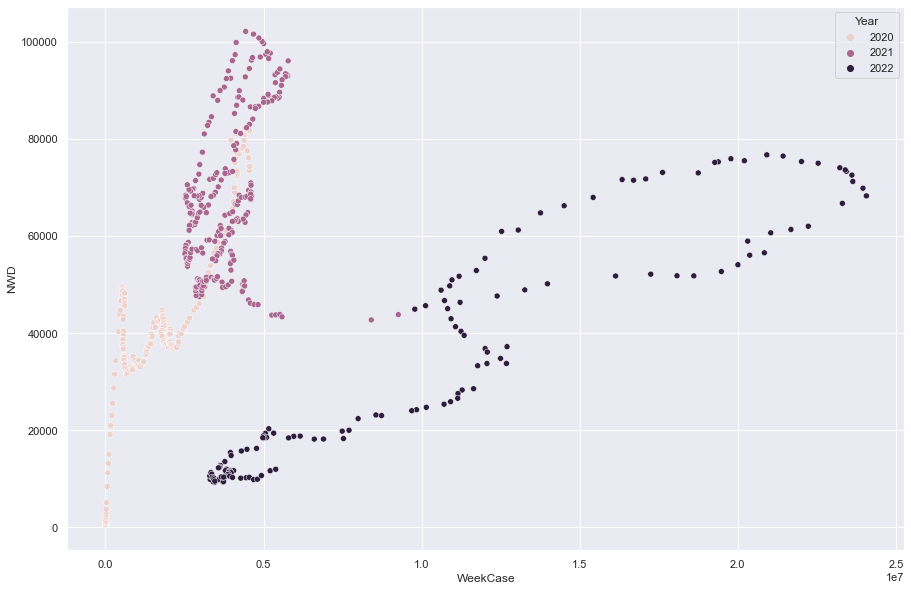

In [29]:
g = sns.scatterplot(
    data = train_data[train_data['Location'] =='World'],
    x = "WeekCase",
    y = "NWD",
    hue = "Year",
)


Based on the plot above the gradient of Number of Weekly Death compared to Weekly Cases become less and less steep over the year. This means that there are less deaths in the same amount of covid case over the year.

Another arbitrary location  Ecuador  is taken.


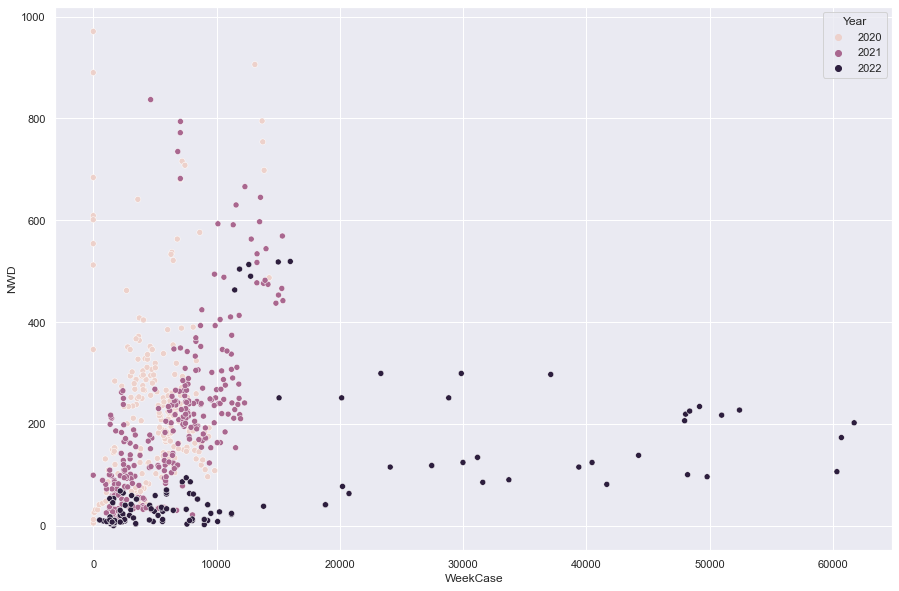

In [30]:
random_location = random.choice(train_data['Location'].unique())
g = sns.scatterplot(
    data = train_data[train_data['Location']== random_location],
    x = "WeekCase",
    y = "NWD",
    hue = "Year",
)
print('Another arbitrary location ', random_location,' is taken.')

Location are given labels as follows


*   World = for an unparticular country
*   AS = for Asian countries
*   AF = for African countries
*   NA = for North American countries
*   SA = for South American countries
*   OC = for Oceanian countries

Aside from their geograhical location, some data are labeled based on their income level:
*   Low income
*   Lower middle income
*   Upper middle income
*   High income

However, no information on the native data is given on how these income are tiered. 

In [31]:

train_coded_location = decode_input(train_data, return_file = True)
test_coded_location = decode_input(test_data, return_file = True)

In [32]:
train_coded_location.tail()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun,NWD
129151,Zimbabwe,464.0,2022,29.012,13.0,0.813,11949993.0,6297324.0,4601845.0,1050824.0,5665.0,74.72,39.37,28.77,6.57,354.0,1427.0,0.009,9.0
129152,Zimbabwe,471.0,2022,29.449,12.0,0.750,11958771.0,6299348.0,4605821.0,1053602.0,5295.0,74.77,39.39,28.80,6.59,331.0,1362.0,0.009,7.0
129153,Zimbabwe,450.0,2022,28.136,13.0,0.813,0.0,0.0,0.0,0.0,5316.0,0.00,0.00,0.00,0.00,332.0,1483.0,0.009,5.0
129154,Zimbabwe,277.0,2022,17.320,6.0,0.375,11974313.0,6305470.0,4611113.0,1057730.0,5358.0,74.87,39.43,28.83,6.61,335.0,1633.0,0.010,7.0
129155,Zimbabwe,277.0,2022,17.320,6.0,0.375,11984914.0,6310089.0,4614738.0,1060087.0,6190.0,74.94,39.45,28.85,6.63,387.0,2102.0,0.013,8.0


In [33]:
train_coded_location['Location'].unique()

array(['World', 'Afghanistan', 'AF', 'Albania', 'Algeria', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'AS', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'SA',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'EU', 'Fiji', 'Finland', 'France',
       'French Polynesia', 'Gabon', 'Gambia', 'Geor

In [34]:
test_coded_location['Location'].unique()

array(['Monaco', 'Liechtenstein', 'Albania', 'Niger', 'French Polynesia',
       'Slovenia', 'Mali', 'Cayman Islands', 'Trinidad and Tobago',
       'Chad', 'Turkey', 'Croatia', 'Rwanda', 'Singapore',
       'Turks and Caicos Islands', 'Saint Lucia', 'Portugal', 'AS',
       'Georgia', 'Morocco', 'SA', 'AF', 'Cyprus', 'Nepal', 'Germany',
       'Lithuania', 'Austria', 'Panama', 'Maldives', 'Comoros',
       'Solomon Islands', 'New Zealand', 'Djibouti', 'Malawi', 'Nigeria',
       'Haiti', 'Argentina', 'Brazil', 'Montenegro', 'Canada', 'Angola',
       'Antigua and Barbuda', 'Togo', 'Norway', 'Montserrat',
       'Uzbekistan', 'Vanuatu', 'Estonia', 'Sao Tome and Principe',
       'Uruguay', 'Sweden', 'Mauritius', 'Serbia', 'China', 'Zimbabwe',
       'Cape Verde', 'NA', 'Yemen', 'Japan', 'Sierra Leone', 'Denmark',
       'Wallis and Futuna', 'Upper middle income', 'Myanmar', 'France',
       'Namibia', 'Cuba', 'Russia', 'Guyana', 'South Korea',
       'Lower middle income', 'Hong Kong',

In [35]:
continents = ['EU', 'AF', 'OC', 'NA', 'AS', 'SA']
income_class = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

In [36]:
continents_data = selectrows(train_coded_location, 'Location', continents)

In [37]:
continents_data.head()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun,NWD
1283,AF,0.0,2020,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1284,AF,0.0,2020,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,AF,0.0,2020,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1286,AF,0.0,2020,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287,AF,1.0,2020,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
income_data = selectrows(train_coded_location, 'Location', income_class)

In [39]:
income_data.head()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun,NWD
52710,High income,43.0,2020,0.035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52711,High income,57.0,2020,0.046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52712,High income,67.0,2020,0.054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52713,High income,87.0,2020,0.070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52714,High income,95.0,2020,0.077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<AxesSubplot:xlabel='Year', ylabel='WeekCasePerMil'>

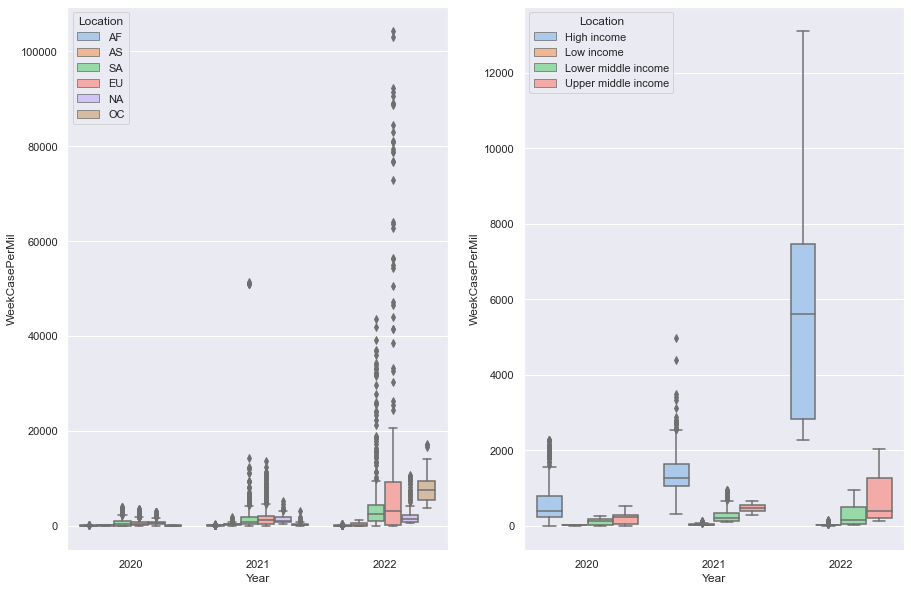

In [40]:
fig, axs = plt.subplots(ncols = 2)

sns.boxplot(x = 'Year', y = 'WeekCasePerMil', data= continents_data, hue = 'Location', palette= 'pastel', ax = axs[0])
sns.boxplot(x = 'Year', y = 'WeekCasePerMil', data= income_data, hue = 'Location', palette= 'pastel', ax = axs[1])

[Text(0.5, 1.0, 'High income')]

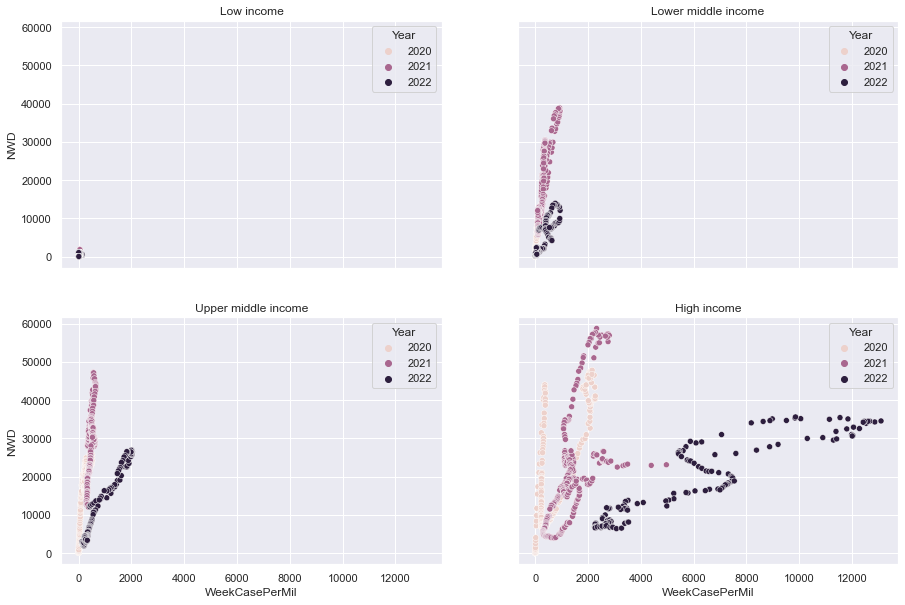

In [41]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, sharey= True, sharex= True)

x_axis = "WeekCasePerMil"
y_axis = "NWD"
hue_plot = "Year"

sns.scatterplot(
    data = income_data[income_data['Location']== income_class[0]],
    x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[0][0]
).set(title = income_class[0])
sns.scatterplot(
    data = income_data[income_data['Location']== income_class[1]],
    x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[0][1]
).set(title = income_class[1])
sns.scatterplot(
    data = income_data[income_data['Location']== income_class[2]],
   x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[1][0]
).set(title = income_class[2])
sns.scatterplot(
    data = income_data[income_data['Location']== income_class[3]],
   x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[1][1]
).set(title = income_class[3])

Based on the plots above the gradient of Number of Weekly Death compared to Weekly Cases become generally less steep over the year, these are apparent in upper middle income and high income locations. This means that there are less deaths in the same amount of covid case over the year for those locations. 

Looking at the order of magnitude of weekly case per million population, it appears that more cases are recorded as the income level of a population increase. However, we must consider that cases might be more well documented and recorded in locations with higher income. 

[Text(0.5, 1.0, 'High income')]

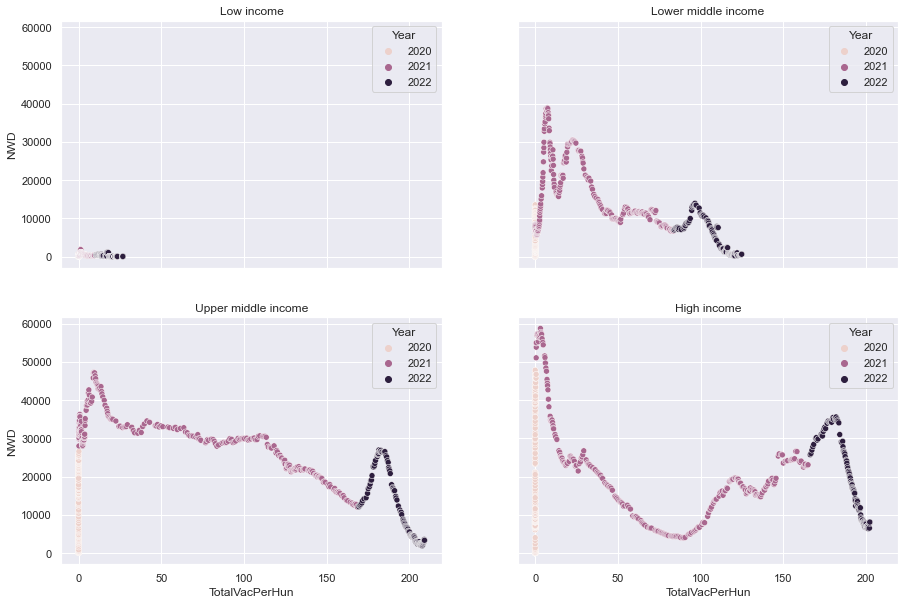

In [42]:
fig, axs = plt.subplots(ncols = 2, nrows = 2, sharey= True, sharex= True)

x_axis = "TotalVacPerHun"
y_axis = "NWD"
hue_plot = "Year"

sns.scatterplot(
    data = income_data[income_data['Location']== income_class[0]],
    x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[0][0]
).set(title = income_class[0])
sns.scatterplot(
    data = income_data[income_data['Location']== income_class[1]],
    x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[0][1]
).set(title = income_class[1])
sns.scatterplot(
    data = income_data[income_data['Location']== income_class[2]],
   x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[1][0]
).set(title = income_class[2])
sns.scatterplot(
    data = income_data[income_data['Location']== income_class[3]],
   x = x_axis,
    y = y_axis,
    hue = hue_plot,
    ax = axs[1][1]
).set(title = income_class[3])

From lower middle income until high income locations it is observed that: 


*   In 2020, number of total vaccinated people per one hundred of population is almost all zero because vaccine has not been invented and deployed
*   The number of vaccinated people increase between 2020 and 2022
*   The wave like plot shows that higher vaccination rate per one hundred of population doesn't always equal to lower NWD. There are ranges where higher number of death recorded with more vaccinated population. 

Replot is done for low income locations to observe the tendance as it is not too apparent when plotted in the same scale with other income levels. 







[Text(0.5, 1.0, 'Low income')]

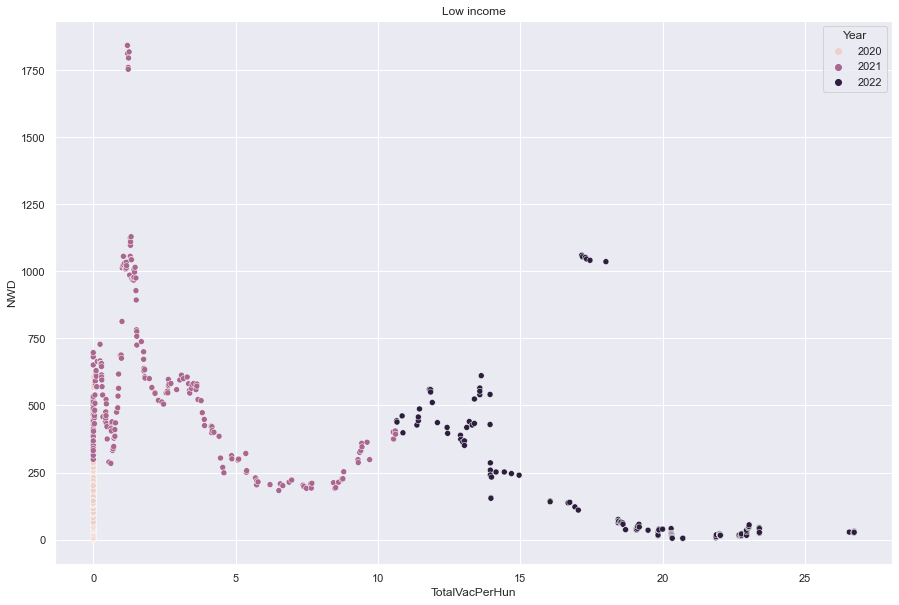

In [43]:
x_axis = "TotalVacPerHun"
y_axis = "NWD"
hue_plot = "Year"

sns.scatterplot(
    data = income_data[income_data['Location']== income_class[0]],
    x = x_axis,
    y = y_axis,
    hue = hue_plot,
).set(title = income_class[0])

The trends as stated above is also applicable to low income countries. However, the order of magnitude of vaccinated people per hundred of population is almost ten times lower than upper middle and high income countries.

In [44]:
train_coded_location['Year'].unique()

array([2020, 2021, 2022], dtype=int64)

Map Year into different codes

In [45]:
def map_year(row):
  if row == 2022:
    row = "2"
  if row == 2020:
    row = "0"
  if row == 2021:
    row = "1"
  return row 


In [46]:
train_coded_location['Year'] = train_coded_location['Year'].apply(map_year)
test_coded_location['Year'] = test_coded_location['Year'].apply(map_year)

In [47]:
train_coded_location.tail()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun,NWD
129151,Zimbabwe,464.0,2,29.012,13.0,0.813,11949993.0,6297324.0,4601845.0,1050824.0,5665.0,74.72,39.37,28.77,6.57,354.0,1427.0,0.009,9.0
129152,Zimbabwe,471.0,2,29.449,12.0,0.750,11958771.0,6299348.0,4605821.0,1053602.0,5295.0,74.77,39.39,28.80,6.59,331.0,1362.0,0.009,7.0
129153,Zimbabwe,450.0,2,28.136,13.0,0.813,0.0,0.0,0.0,0.0,5316.0,0.00,0.00,0.00,0.00,332.0,1483.0,0.009,5.0
129154,Zimbabwe,277.0,2,17.320,6.0,0.375,11974313.0,6305470.0,4611113.0,1057730.0,5358.0,74.87,39.43,28.83,6.61,335.0,1633.0,0.010,7.0
129155,Zimbabwe,277.0,2,17.320,6.0,0.375,11984914.0,6310089.0,4614738.0,1060087.0,6190.0,74.94,39.45,28.85,6.63,387.0,2102.0,0.013,8.0


In [48]:
print(test_coded_location['Location'].unique())
print(train_coded_location['Location'].unique())

['Monaco' 'Liechtenstein' 'Albania' 'Niger' 'French Polynesia' 'Slovenia'
 'Mali' 'Cayman Islands' 'Trinidad and Tobago' 'Chad' 'Turkey' 'Croatia'
 'Rwanda' 'Singapore' 'Turks and Caicos Islands' 'Saint Lucia' 'Portugal'
 'AS' 'Georgia' 'Morocco' 'SA' 'AF' 'Cyprus' 'Nepal' 'Germany' 'Lithuania'
 'Austria' 'Panama' 'Maldives' 'Comoros' 'Solomon Islands' 'New Zealand'
 'Djibouti' 'Malawi' 'Nigeria' 'Haiti' 'Argentina' 'Brazil' 'Montenegro'
 'Canada' 'Angola' 'Antigua and Barbuda' 'Togo' 'Norway' 'Montserrat'
 'Uzbekistan' 'Vanuatu' 'Estonia' 'Sao Tome and Principe' 'Uruguay'
 'Sweden' 'Mauritius' 'Serbia' 'China' 'Zimbabwe' 'Cape Verde' 'NA'
 'Yemen' 'Japan' 'Sierra Leone' 'Denmark' 'Wallis and Futuna'
 'Upper middle income' 'Myanmar' 'France' 'Namibia' 'Cuba' 'Russia'
 'Guyana' 'South Korea' 'Lower middle income' 'Hong Kong'
 'Equatorial Guinea' 'Bulgaria' 'OC' 'San Marino' 'Sudan' 'Ireland'
 'Syria' 'Zambia' 'Mongolia' 'Ukraine' 'Bahrain' 'Oman' 'Tanzania'
 'Mozambique' 'Gabon' 'Kyrgyz

Map Location into different codes

In [49]:
location_map = {'EU' : "1",
                'AS' : "2",
                'AF' : "3",
                'OC' : "4",
                'SA' : "5",
                'World' : "6",
                'NA' : "7",
                'High income' : "8",
                'Low income' : "9",
                'Upper middle income' : "10",
                'Lower middle income' : "11"
                }

In [50]:
train_coded_location['Location'] = train_coded_location['Location'].map(location_map)
test_coded_location['Location'] = test_coded_location['Location'].map(location_map)

In [51]:
train_coded_location.head()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun,NWD
0,6,2372.0,0,0.300,65.0,0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,344.0
1,6,5023.0,0,0.635,114.0,0.014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.0
2,6,5612.0,0,0.710,116.0,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,431.0
3,6,7580.0,0,0.958,153.0,0.019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,463.0
4,6,8983.0,0,1.136,187.0,0.024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,506.0


In [52]:
test_coded_location.tail()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun
43047,NaN,585.0,1,915.033,0.0,0.000,766418.0,408405.0,0.0,455.0,991.0,119.88,63.88,0.00,0.07,1550.0,466.0,0.073
43048,NaN,18120.0,0,351.732,584.0,11.336,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
43049,NaN,38399.0,1,570.725,592.0,8.799,30691557.0,28327873.0,2363684.0,0.0,598286.0,45.62,42.10,3.51,0.00,8892.0,498281.0,0.741
43050,NaN,22.0,0,24.553,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
43051,NaN,5030.0,2,139.915,12.0,0.334,60840610.0,25943822.0,24177054.0,10719734.0,81787.0,169.23,72.17,67.25,29.82,2275.0,11147.0,0.031


Split train data into train and validation

In [53]:
label_column = "NWD"
test_size = 0.2

In [54]:
train_model = train_coded_location
test_model = test_coded_location

In [55]:
input_df, output_df = split_input_output(train_model, label_column)

In [56]:
X_train, X_valid, y_train, y_valid = split_train_validation(input_df,
                                                    output_df,
                                                    test_size)

In [57]:
X_test = test_coded_location

In [58]:
# Sanity check
print(f"input size        : {train_model.shape}")
print(f"test size         : {X_test.shape}")
print(f"train size        : {X_train.shape}")
print(f"validation size   : {X_valid.shape}")
print(f"column number       : {len(train_data.columns)}")
print(f"test_train ratio    : {X_test.shape[0]/train_data.shape[0]:.2f}")
print(f"valid_train ratio   : {X_valid.shape[0]/(train_data.shape[0]-X_test.shape[0]):.2f}")

input size        : (129156, 19)
test size         : (43052, 18)
train size        : (103324, 18)
validation size   : (25832, 18)
column number       : 20
test_train ratio    : 0.33
valid_train ratio   : 0.30


In [59]:
numerical_columns, categorical_columns = categorize_input(X_train)

In [60]:
categorical_columns

['Location', 'Year']

In [61]:
numerical_columns

['WeekCase',
 'WeekCasePerMil',
 'WeekDeath',
 'WeekDeathPerMil',
 'TotalVac',
 'PeopleVac',
 'PeopleFullVac',
 'TotalBoost',
 'DailyVac',
 'TotalVacPerHun',
 'PeopleVacPerHun',
 'PeopleFullVacPerHun',
 'TotalBoostPerHun',
 'DailyVacPerHun',
 'DailyPeopleVac',
 'DailyPeopleVacPerHun']

In [62]:
X_train.head()

,Location,WeekCase,Year,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun
122766,NaN,1244741.0,2,18500.621,1308.0,19.441,135357499.0,51974605.0,47718730.0,35664164.0,268621.0,201.18,77.25,70.92,53.01,3993.0,24730.0,0.037
9741,NaN,16.0,0,39.225,2.0,4.903,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
65858,NaN,11069.0,1,2604.401,50.0,11.764,0.0,0.0,0.0,0.0,11572.0,0.00,0.00,0.00,0.00,2723.0,8291.0,0.195
16853,NaN,111.0,0,33.935,11.0,3.363,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
39499,NaN,6502.0,1,4893.501,78.0,58.704,1586906.0,817582.0,776275.0,151375.0,5890.0,119.43,61.53,58.42,11.39,4433.0,992.0,0.075


In [63]:
X_train[categorical_columns].head()

,Location,Year
122766,NaN,2
9741,NaN,0
65858,NaN,1
16853,NaN,0
39499,NaN,1


In [64]:
X_test[numerical_columns].head()

,WeekCase,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun
0,185.0,5042.796,0.0,0.00,0.0,0.0,0.0,0.0,158.0,0.00,0.00,0.00,0.0,4307.0,23.0,0.063
1,78.0,1998.002,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000
2,230.0,80.569,1.0,0.35,0.0,0.0,0.0,0.0,1462.0,0.00,0.00,0.00,0.0,512.0,391.0,0.014
3,14.0,0.554,1.0,0.04,0.0,0.0,0.0,0.0,72018.0,0.00,0.00,0.00,0.0,2852.0,60442.0,0.239
4,1033.0,3397.669,0.0,0.00,366984.0,186177.0,180807.0,0.0,22.0,120.71,61.24,59.47,0.0,72.0,22.0,0.007


Data has been split into train, validation, and test. 
Categorical columns have been separated from numerical columns and given codes. 
Data is ready for modeling. 

In [65]:
##X_train[numerical_columns] = normalize_input(X_train[numerical_columns], state = "fit")

In [66]:
X_train[numerical_columns].head()

,WeekCase,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun
122766,1244741.0,18500.621,1308.0,19.441,135357499.0,51974605.0,47718730.0,35664164.0,268621.0,201.18,77.25,70.92,53.01,3993.0,24730.0,0.037
9741,16.0,39.225,2.0,4.903,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
65858,11069.0,2604.401,50.0,11.764,0.0,0.0,0.0,0.0,11572.0,0.00,0.00,0.00,0.00,2723.0,8291.0,0.195
16853,111.0,33.935,11.0,3.363,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
39499,6502.0,4893.501,78.0,58.704,1586906.0,817582.0,776275.0,151375.0,5890.0,119.43,61.53,58.42,11.39,4433.0,992.0,0.075


In [67]:
##X_test[numerical_columns] = normalize_input(X_test[numerical_columns], state = "fit")

In [68]:
X_test[numerical_columns].head()

,WeekCase,WeekCasePerMil,WeekDeath,WeekDeathPerMil,TotalVac,PeopleVac,PeopleFullVac,TotalBoost,DailyVac,TotalVacPerHun,PeopleVacPerHun,PeopleFullVacPerHun,TotalBoostPerHun,DailyVacPerHun,DailyPeopleVac,DailyPeopleVacPerHun
0,185.0,5042.796,0.0,0.00,0.0,0.0,0.0,0.0,158.0,0.00,0.00,0.00,0.0,4307.0,23.0,0.063
1,78.0,1998.002,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000
2,230.0,80.569,1.0,0.35,0.0,0.0,0.0,0.0,1462.0,0.00,0.00,0.00,0.0,512.0,391.0,0.014
3,14.0,0.554,1.0,0.04,0.0,0.0,0.0,0.0,72018.0,0.00,0.00,0.00,0.0,2852.0,60442.0,0.239
4,1033.0,3397.669,0.0,0.00,366984.0,186177.0,180807.0,0.0,22.0,120.71,61.24,59.47,0.0,72.0,22.0,0.007


In [69]:
##X_valid[numerical_columns] = normalize_input(X_valid[numerical_columns], state = "fit")

In [70]:
clf, r_squared, accuracy, coef_, y_pred = train_model_LR(X_train, y_train, X_valid, y_valid, regularization=None, alpha=0.01)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [71]:
y_pred

NameError: name 'y_pred' is not defined

In [72]:
len(y_pred)

NameError: name 'y_pred' is not defined

In [73]:
y_valid

116314       0.0
11673        0.0
113370      13.0
109659       0.0
118100       0.0
           ...  
121924      23.0
7804      1658.0
31270      491.0
108199       0.0
99110       10.0
Name: NWD, Length: 25832, dtype: float64

In [ ]:
plt.scatter(y_valid, y_pred, alpha = 0.4)
plt.xlabel("Actual Deaths")
plt.ylabel("Predicted Deaths")
plt.show()

In [ ]:
accuracy

In [ ]:
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])
X_valid[numerical_columns] = scaler.fit_transform(X_valid[numerical_columns])

In [ ]:
X_train[numerical_columns].head()

In [ ]:
X_test[numerical_columns].head()

In [ ]:
X_train.head()

In [ ]:
clf_normalized, r_squared_normalized, accuracy_normalized, coef_normalized, y_pred_normalized = train_model_LR(X_train, y_train, X_valid, y_valid, regularization='Ridge', alpha=0.01)

In [ ]:
plt.scatter(y_valid, y_pred_normalized, alpha = 0.4)
plt.xlabel("Actual Deaths")
plt.ylabel("Predicted Deaths")
plt.show()

In [ ]:
accuracy_normalized